# EfficientNet baseline test

In [1]:
import numpy as np
import pandas as pd
import h5py
import torch
import cv2
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import os
from torch.utils.data import Dataset
from torchvision import transforms, models
from torchvision.models import efficientnet_b3, EfficientNet_B3_Weights
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from tqdm import tqdm
from dataset import HDF5Dataset

## Preprocess Data

In [2]:
# Load metadata
metadata = pd.read_csv("../train-metadata.csv")
hdf5 = h5py.File("../train-image.hdf5", "r")

# Sample balanced malignant and benign
malignant_ids = metadata[metadata["target"] == 1].sample(n=393, random_state=42)["isic_id"].tolist()
benign_ids = metadata[metadata["target"] == 0].sample(n=393, random_state=42)["isic_id"].tolist()

def load_images(ids):
    images = []
    labels = []
    for image_id in ids:
        image = hdf5[image_id][()]
        image = np.frombuffer(image, dtype=np.uint8)
        image = cv2.imdecode(image, cv2.IMREAD_COLOR)
        image = cv2.resize(image, (128, 128))
        images.append(image)
        labels.append(1 if image_id in malignant_ids else 0)
    return images, labels

images_mal, labels_mal = load_images(malignant_ids)
images_ben, labels_ben = load_images(benign_ids)

# Combine and split
all_images = np.array(images_mal + images_ben)
all_labels = np.array(labels_mal + labels_ben)

X_train, X_val, y_train, y_val = train_test_split(all_images, all_labels, test_size=0.1, stratify=all_labels, random_state=42)

/tmp/ipykernel_3939685/2231450438.py:2: DtypeWarning: Columns (51,52) have mixed types. Specify dtype option on import or set low_memory=False.
  metadata = pd.read_csv("../train-metadata.csv")


In [3]:
train_dataset = HDF5Dataset(X_train, y_train, augment=True)
val_dataset = HDF5Dataset(X_val, y_val, augment=False)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=1)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=1)

## Train

In [4]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [11]:
weights = EfficientNet_B3_Weights.DEFAULT
model = efficientnet_b3(weights=weights)
model.classifier[1] = nn.Linear(model.classifier[1].in_features, 1)
model = model.to(device)
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

In [12]:
num_epochs = 20
train_losses, val_losses = [], []
val_accuracies = []
val_precisions = []
val_recalls = []
val_f1s = []

In [13]:
for epoch in range(num_epochs):
    model.train()
    epoch_loss = 0

    for inputs, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}"):
        inputs = inputs.to(device)
        labels = labels.float().unsqueeze(1).to(device)  # [B, 1]

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()

    train_losses.append(epoch_loss / len(train_loader))

    # === Validation ===
    model.eval()
    val_loss = 0
    preds, targets = [], []

    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs = inputs.to(device)
            labels = labels.float().unsqueeze(1).to(device)

            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

            preds.extend(torch.sigmoid(outputs).cpu().numpy())
            targets.extend(labels.cpu().numpy())

    val_losses.append(val_loss / len(val_loader))
    val_auc = roc_auc_score(targets, preds)
    
    # Threshold predictions at 0.5
    pred_labels = (np.array(preds) >= 0.5).astype(int)
    true_labels = np.array(targets).astype(int)

    val_acc = accuracy_score(true_labels, pred_labels)
    val_precision = precision_score(true_labels, pred_labels)
    val_recall = recall_score(true_labels, pred_labels)
    val_f1 = f1_score(true_labels, pred_labels)

    print(f"Epoch {epoch+1}: Acc = {val_acc:.4f}, Precision = {val_precision:.4f}, Recall = {val_recall:.4f}, F1 = {val_f1:.4f}") 
    val_accuracies.append(val_acc)
    val_precisions.append(val_precision)
    val_recalls.append(val_recall)
    val_f1s.append(val_f1)
    torch.save({
        'epoch': epoch + 1,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'train_loss': train_losses[-1],
        'val_loss': val_losses[-1],
        'val_auc': val_auc
    }, f"checkpoints/efficientnet_epoch_{epoch+1}.pth")

Epoch 1/20: 100%|██████████| 23/23 [00:04<00:00,  4.78it/s]


Epoch 1: Acc = 0.6962, Precision = 0.7027, Recall = 0.6667, F1 = 0.6842


Epoch 2/20: 100%|██████████| 23/23 [00:04<00:00,  4.72it/s]


Epoch 2: Acc = 0.7342, Precision = 0.7045, Recall = 0.7949, F1 = 0.7470


Epoch 3/20: 100%|██████████| 23/23 [00:04<00:00,  4.77it/s]


Epoch 3: Acc = 0.7975, Precision = 0.8286, Recall = 0.7436, F1 = 0.7838


Epoch 4/20: 100%|██████████| 23/23 [00:04<00:00,  4.76it/s]


Epoch 4: Acc = 0.7975, Precision = 0.8108, Recall = 0.7692, F1 = 0.7895


Epoch 5/20: 100%|██████████| 23/23 [00:04<00:00,  4.77it/s]


Epoch 5: Acc = 0.7975, Precision = 0.7949, Recall = 0.7949, F1 = 0.7949


Epoch 6/20: 100%|██████████| 23/23 [00:04<00:00,  4.78it/s]


Epoch 6: Acc = 0.8228, Precision = 0.8378, Recall = 0.7949, F1 = 0.8158


Epoch 7/20: 100%|██████████| 23/23 [00:04<00:00,  4.72it/s]


Epoch 7: Acc = 0.8101, Precision = 0.8000, Recall = 0.8205, F1 = 0.8101


Epoch 8/20: 100%|██████████| 23/23 [00:04<00:00,  4.75it/s]


Epoch 8: Acc = 0.8101, Precision = 0.8158, Recall = 0.7949, F1 = 0.8052


Epoch 9/20: 100%|██████████| 23/23 [00:04<00:00,  4.77it/s]


Epoch 9: Acc = 0.7975, Precision = 0.7949, Recall = 0.7949, F1 = 0.7949


Epoch 10/20: 100%|██████████| 23/23 [00:04<00:00,  4.66it/s]


Epoch 10: Acc = 0.8101, Precision = 0.8000, Recall = 0.8205, F1 = 0.8101


Epoch 11/20: 100%|██████████| 23/23 [00:04<00:00,  4.75it/s]


Epoch 11: Acc = 0.7975, Precision = 0.8108, Recall = 0.7692, F1 = 0.7895


Epoch 12/20: 100%|██████████| 23/23 [00:04<00:00,  4.77it/s]


Epoch 12: Acc = 0.8481, Precision = 0.8857, Recall = 0.7949, F1 = 0.8378


Epoch 13/20: 100%|██████████| 23/23 [00:04<00:00,  4.78it/s]


Epoch 13: Acc = 0.7975, Precision = 0.7674, Recall = 0.8462, F1 = 0.8049


Epoch 14/20: 100%|██████████| 23/23 [00:04<00:00,  4.73it/s]


Epoch 14: Acc = 0.7975, Precision = 0.7949, Recall = 0.7949, F1 = 0.7949


Epoch 15/20: 100%|██████████| 23/23 [00:04<00:00,  4.78it/s]


Epoch 15: Acc = 0.7975, Precision = 0.7805, Recall = 0.8205, F1 = 0.8000


Epoch 16/20: 100%|██████████| 23/23 [00:04<00:00,  4.79it/s]


Epoch 16: Acc = 0.7722, Precision = 0.7561, Recall = 0.7949, F1 = 0.7750


Epoch 17/20: 100%|██████████| 23/23 [00:04<00:00,  4.77it/s]


Epoch 17: Acc = 0.8354, Precision = 0.8250, Recall = 0.8462, F1 = 0.8354


Epoch 18/20: 100%|██████████| 23/23 [00:04<00:00,  4.79it/s]


Epoch 18: Acc = 0.8228, Precision = 0.8205, Recall = 0.8205, F1 = 0.8205


Epoch 19/20: 100%|██████████| 23/23 [00:04<00:00,  4.78it/s]


Epoch 19: Acc = 0.8228, Precision = 0.8378, Recall = 0.7949, F1 = 0.8158


Epoch 20/20: 100%|██████████| 23/23 [00:04<00:00,  4.78it/s]


Epoch 20: Acc = 0.7975, Precision = 0.7805, Recall = 0.8205, F1 = 0.8000


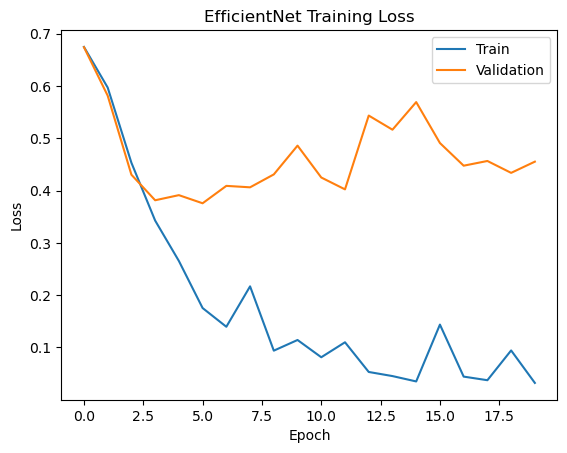

In [14]:
plt.plot(train_losses, label='Train')
plt.plot(val_losses, label='Validation')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("EfficientNet Training Loss")
plt.legend()
plt.savefig("EfficientNet_loss_curve.png")